# Cell Type Specific Age Prediction Models using scRNA-seq Data

### Matthew T. Buckley
Started: Jan 6 2018  
Last modified: Jan 6 2018  
Data produced by Ben Dulken and myself in the Brunet Lab, Stanford University.  
Project begun in Stanford's CS229 Class. 

In [20]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [25]:
# Plot settings
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [5]:
# Load labeled scRNA-seq Data
os.chdir(os.getenv("HOME") + "/Desktop/Dropbox/CS229/Project")
d = pd.read_table("./data/svz_data.txt", sep=",")
d = d.drop("Unnamed: 0", axis=1)

NameError: name 'head' is not defined

In [10]:
d[0:10]

,nGene,nUMI,orig.ident,percent.mito,Age,Replicate,Celltype,Xkr4,Sox17,Mrpl15,...,AC102264.1,AC125149.3,AC125149.5,AC125149.1,AC125149.2,AC125149.4,AC234645.1,AC168977.2,AC168977.1,Vmn2r122
0,3106,8320,y1,0.022476,y,1,aNSCs_NPCs,0.0,0.00000,0.789331,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
1,1738,3517,y1,0.023031,y,1,aNSCs_NPCs,0.0,1.34634,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
2,899,1380,y1,0.046377,y,1,Pericytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
3,664,955,y1,0.026178,y,1,Pericytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
4,1127,2196,y1,0.076047,y,1,Oligodendrocytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
5,1392,2890,y1,0.036332,y,1,Oligodendrocytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
6,1481,3706,y1,0.039935,y,1,Microglia,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
7,1086,2104,y1,0.059886,y,1,Oligodendrocytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
8,1508,3973,y1,0.033224,y,1,Microglia,0.0,0.00000,1.257605,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
9,528,845,y1,0.024852,y,1,Oligodendrocytes,0.0,0.00000,0.000000,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0


In [11]:
# Subset the most frequent cell types then age balance. 
d.endo = d[d.Celltype == "Endothelial"]
d.endo.o = d.endo[d.endo.Age == "o"] # 1149 cells. Mean genes detected per cell: 1155.78
d.endo.y = d.endo[d.endo.Age == "y"] # 991, 1179.85 (-2% delta with age)

d.oligo = d[d.Celltype == "Oligodendrocytes"]
d.oligo.o = d.oligo[d.oligo.Age == "o"] # 691, mean genes 1490.86
d.oligo.y = d.oligo[d.oligo.Age == "y"] # 966, 1492.18 (0% delta)

d.micro = d[d.Celltype == "Microglia"]
d.micro.o = d.micro[d.micro.Age == "o"] # 989, mean genes 1386.62
d.micro.y = d.micro[d.micro.Age == "y"] # 747, 1217.98 (+12% delta with age)

d.astroq = d[d.Celltype == "Astrocytes_qNSCs"]
d.astroq.o = d.astroq[d.astroq.Age == "o"] # 600, mean genes 1128.00
d.astroq.y = d.astroq[d.astroq.Age == "y"] # 407, 1163.11 (-3% delta with age)

# Lowest number is 407. Thus randomly sample 407 rows
# from each age/celltype combination, then combine
# into age balanced cell type specific matrices.

In [12]:
# Variables and Constants
s = 407 # sample number
rs = 7 # random state

In [13]:
# Age balance
endo_o = d.endo.o.sample(n=s, random_state = rs)
endo_y = d.endo.y.sample(n=s, random_state = rs)
endo_bal = pd.concat((endo_y, endo_o))

oligo_o = d.oligo.o.sample(n=s, random_state = rs)
oligo_y = d.oligo.y.sample(n=s, random_state = rs)
oligo_bal = pd.concat((oligo_y, oligo_o))

micro_o = d.micro.o.sample(n=s, random_state = rs)
micro_y = d.micro.y.sample(n=s, random_state = rs)
micro_bal = pd.concat((micro_y, micro_o))

astroq_o = d.astroq.o.sample(n=s, random_state = rs)
astroq_y = d.astroq.y.sample(n=s, random_state = rs)
astroq_bal = pd.concat((astroq_y, astroq_o))

In [14]:
# Dictionary of balanced celltypes
d_celltypes = dict()
d_celltypes["Endothelial"] = endo_bal
d_celltypes["Oligodendrocytes"] = oligo_bal
d_celltypes["Microglia"] = micro_bal
d_celltypes["Astrocytes_qNSCs"] = astroq_bal

In [17]:
# L2 LOGISTIC REGRESSION
clf = LogisticRegression(C = .01, penalty = "l2")

In [18]:
cell_model_data = dict()

for c in d_celltypes.keys():
    # Split data
    y = pd.factorize(d_celltypes[c].Age)[0]
    X = d_celltypes[c].iloc[:, 7:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=rs, shuffle=True)
    # Train model
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    probs = clf.predict_proba(X_test)[:, 1]
    acc_test = np.mean(pred == y_test)
    print(c)
    print(acc_test)
    cell_model_data[c] = [probs, pred, X_train, X_test, y_train, y_test, acc_test]

Endothelial
0.969325153374
Oligodendrocytes
0.926380368098
Microglia
0.944785276074
Astrocytes_qNSCs
0.926380368098


In [21]:
multi_roc = dict()
for c in d_celltypes.keys():
    # Load cell type specific classifer and relevant data
    probs, pred, X_train, X_test, y_train, y_test, acc_test = cell_model_data[c]
    # Metrics and Plots
    ## AUC
    fpr, tpr, thresh = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    multi_roc[c] = [fpr, tpr, roc_auc]

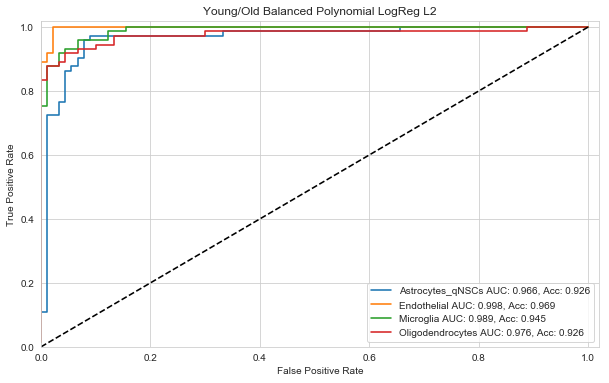

In [27]:
# AUROC Plot for all 4 models. 
plt.figure()
lw = 1.6
for c in ['Astrocytes_qNSCs', 'Endothelial', 'Microglia', "Oligodendrocytes"]:
    plt.plot(multi_roc[c][0], multi_roc[c][1], lw=lw, label='{0} AUC: {1:0.3f}, Acc: {2:0.3f}'.format(c, multi_roc[c][2], cell_model_data[c][6]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Young/Old Balanced Polynomial LogReg L2')
plt.legend(loc="lower right")
plt.show()

This AUROC plot reveals the surprisingly good performance of L2 logistic regression based cell type specific young/old age classification models. Age labels are balanced by subsetting before training and testing. Training set n=651 (80%); test set n=163 (20%).  
Classification performance is highest on endothelial cells suggesting that this cell type may experience greater age-associated transcriptomic changes. I was expecting microglia to show this result. 

In [ ]:
TO-DO:
    - tSNE Visualization